In [1]:
import numpy as np
import pandas as pd
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def read_training_data():
    df = pd.read_csv('train.dat', delimiter='\t', names=["antibiofilm","peptides"])
    return df

In [3]:
def read_testing_data():
    df = pd.read_csv('test.dat', delimiter='\t', names=["peptides"])
    return df

In [4]:
def kmer(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [5]:
def kmers(seq, k=2):
    features = []
    for i in range(1,k):
        features.extend(kmer(seq, i))
    return features

In [6]:
def generate_features(X):
    X_features = []
    for x in X:
        X_features.append(kmers(x, 4))

    for item in range(len(X_features)):
        X_features[item] = ' '.join(X_features[item])
    return X_features

In [7]:
def generate_feature_vector(X):
    features = set()
    for x in X:
        features.update(x.split()) 
    features = list(sorted(features))
    return features

In [8]:
def generate_vector(X, features):
    X_vector = np.zeros((len(X),len(features)))
    for i,x in enumerate(X):
        count = Counter(x.split())
        for c, cnt  in count.items(): 
            if c in features:
                X_vector[i][features.index(c)] = cnt
        X_vector[i] = X_vector[i]/np.max(X_vector[i])
    return X_vector

In [9]:
def oversample(X, Y):
    oversample = RandomOverSampler(sampling_strategy=0.3, random_state=65)
    X_over, Y_over = oversample.fit_resample(X, Y)
    return X_over, Y_over

In [10]:
def create_ANN_model(num_input):
    model = nn.Sequential(
    nn.Linear(num_input, 600),
    nn.ReLU(),
    nn.Linear(600, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Tanh())
    return model

In [27]:
def train_ANN_model(model, X_train, Y_train, X_test, Y_test, n_epochs=100):
    training_loss = []
    validation_loss = []
    training_mcc = []
    validation_mcc = []
    
    loss_fn = nn.MSELoss()  
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

    batch_size=128
    
    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            Ybatch = Y_train[i:i+batch_size]
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, Ybatch)
            optimizer.zero_grad() #To set the gradient to 0 as pytorch accumalates gradient over losses
            loss.backward()
            optimizer.step()
        
        #scheduler.step()
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred, Y_train)
        training_loss.append(loss.detach().numpy())
        y_pred = np.where(y_pred<0, -1, 1)
        training_mcc.append(matthews_corrcoef(y_pred, Y_train))
        print(f'Finished epoch {epoch}, latest loss {loss}, MCC {training_mcc[-1]}') 
        
        model.eval()
        y_pred = model(X_test)
        loss = loss_fn(y_pred, Y_test)
        validation_loss.append(loss.detach().numpy())
        if epoch%20==0:
            plt.scatter(y_pred.detach().numpy(), Y_test.detach().numpy())
            plt.show()
        y_pred = np.where(y_pred<0, -1, 1)
        validation_mcc.append(matthews_corrcoef(y_pred, Y_test))
        print(f'Validation loss {validation_loss[-1]}, Validation MCC {validation_mcc[-1]}')
        
    return model, training_loss, training_mcc, validation_loss, validation_mcc

In [28]:
def plot_loss_graph(training_loss, validation_loss, n_epochs):
    epochs = range(1,n_epochs + 1)
    plt.plot(epochs, training_loss, label='Training loss')
    plt.plot(epochs, validation_loss, label='Validation loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.show()

In [29]:
def plot_mcc_graph(training_mcc, validation_mcc, n_epochs):
    epochs = range(1,n_epochs + 1)
    plt.plot(epochs, training_mcc, label='Training MCC')
    plt.plot(epochs, validation_mcc, label='Validation MCC')

    plt.title('Training and Validation MCC')
    plt.xlabel('Epochs')
    plt.ylabel('MCC')

    plt.legend(loc='best')
    plt.show()

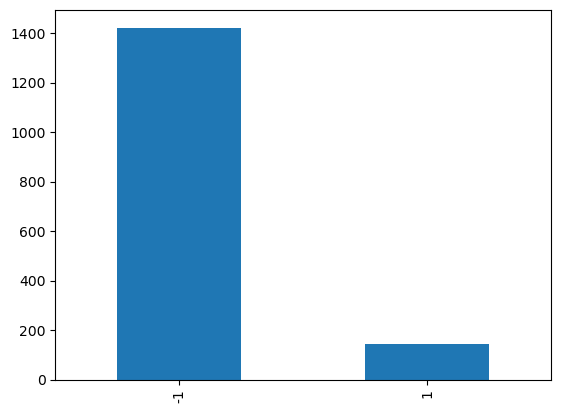

In [30]:
df = read_training_data()  
df['antibiofilm'].value_counts().plot.bar() 
X, Y = df['peptides'].to_numpy(), df['antibiofilm'].to_numpy()

Finished epoch 0, latest loss 0.9642855525016785, MCC 0.44014501076077134


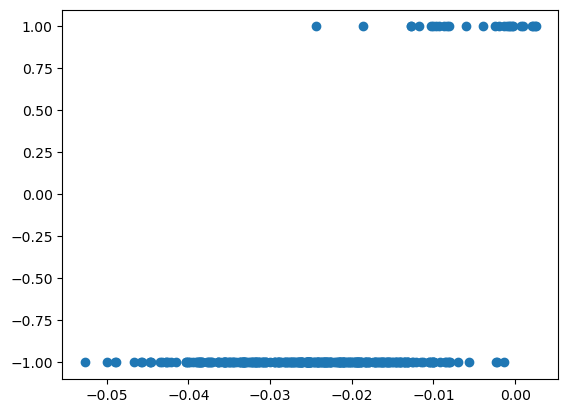

Validation loss 0.9552744626998901, Validation MCC 0.44607128559988557
Finished epoch 1, latest loss 0.9034786820411682, MCC 0.18491367618696783
Validation loss 0.8768974542617798, Validation MCC 0.0
Finished epoch 2, latest loss 0.8230135440826416, MCC 0.16522262113227806
Validation loss 0.7757056951522827, Validation MCC 0.0
Finished epoch 3, latest loss 0.7202475070953369, MCC 0.2672947984750417
Validation loss 0.6479058861732483, Validation MCC 0.2558831578595795
Finished epoch 4, latest loss 0.6094159483909607, MCC 0.31611925471302793
Validation loss 0.5119706392288208, Validation MCC 0.2558831578595795
Finished epoch 5, latest loss 0.5092891454696655, MCC 0.4732098768664399
Validation loss 0.39311936497688293, Validation MCC 0.4065460664114899
Finished epoch 6, latest loss 0.42841532826423645, MCC 0.5860289837166882
Validation loss 0.3058265745639801, Validation MCC 0.5796518270492242
Finished epoch 7, latest loss 0.36296001076698303, MCC 0.7595644759775121
Validation loss 0.2452

In [31]:
X_features = generate_features(X)
features = generate_feature_vector(X_features)
X_vector = generate_vector(X_features, features)
X_train, X_test, y_train, y_test = train_test_split(X_vector, 
                                                    Y, 
                                                    test_size = 0.20, 
                                                    random_state=42, stratify=Y) 
X_over, Y_over = oversample(X_train, y_train)

model = create_ANN_model(X_over.shape[1])
    
Xt_train = torch.tensor(X_over, dtype=torch.float32)
Yt_train = torch.tensor(Y_over, dtype=torch.float32).reshape(-1, 1)

Xt_test = torch.tensor(X_test, dtype=torch.float32)
Yt_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

model, training_loss, training_mcc, validation_loss, validation_mcc = train_ANN_model(model, Xt_train, Yt_train, Xt_test, Yt_test, 15)

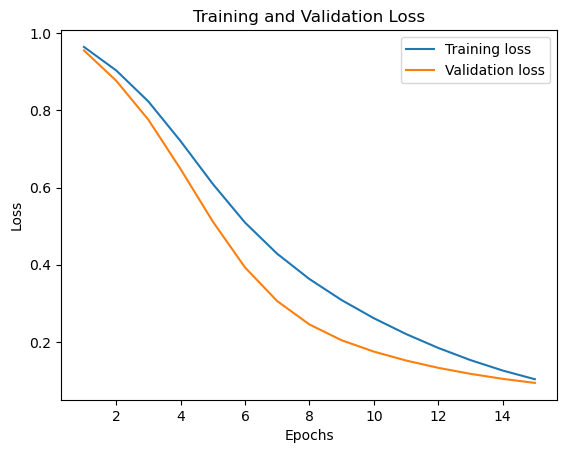

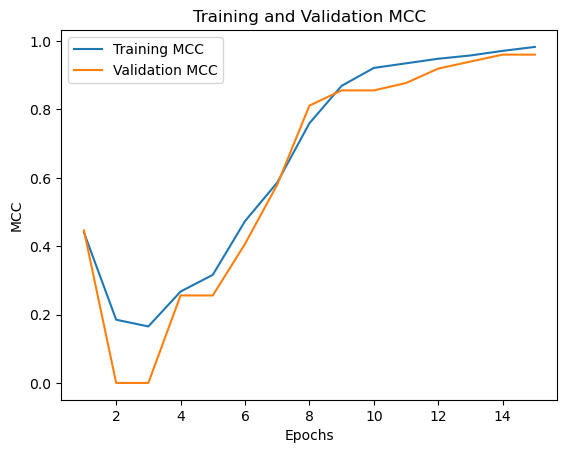

In [33]:
plot_loss_graph(training_loss, validation_loss, 15)
plot_mcc_graph(training_mcc, validation_mcc, 15)

C:\Users\jvenk\AppData\Local\Temp\ipykernel_21668\1230824231.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


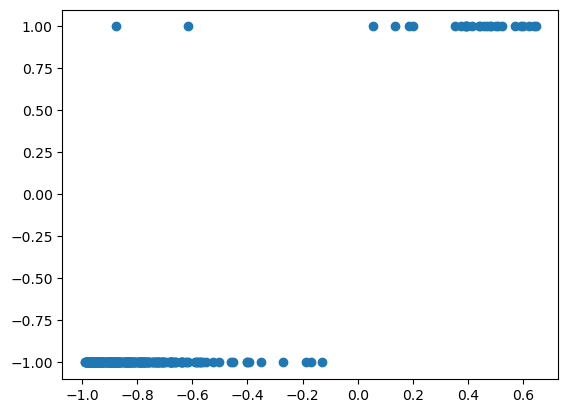

0.9602723654635782


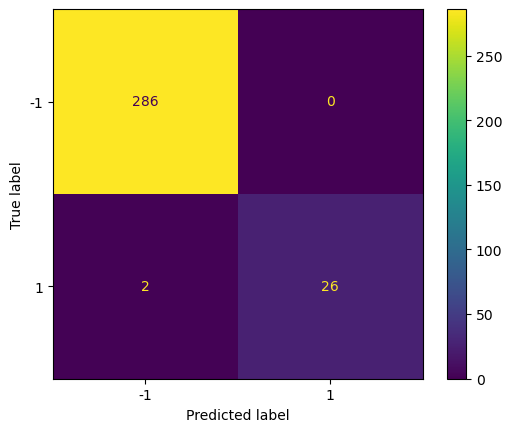

In [35]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_pred = model(X_test) 

plt.scatter(y_pred.detach().numpy(), y_test)
plt.show()

y_pred = np.where(y_pred < 0, -1, 1)
print(matthews_corrcoef(y_pred, y_test)) 

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()